<a href="https://colab.research.google.com/github/yeedas/Musicreviews/blob/master/AmazonMusicReviews_WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is to learn about the word embeddings. In the notebook we try sentiment analysis with the amazon music reviews dataset

Connect to the Google Drive

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Connect to the project files on the google drive

In [3]:
project_path = "/content/drive/My Drive/DLCP/NLP/"
Reviews_path = "/content/drive/My Drive/MyDrive/Amazonreviews/Musicreviews/"
GLOVE_PATH = "/content/drive/My Drive/Fake News Challenge/"
#/content/drive/My Drive/MyDrive/Amazonreviews/Musicreviews/573774_1043123_bundle_archive.zip

In [ ]:
from zipfile import ZipFile


In [ ]:
with ZipFile(GLOVE_PATH+'glove.6B.zip', 'r') as z:
  z.extractall()

In [ ]:
with ZipFile(Reviews_path+'573774_1043123_bundle_archive.zip', 'r') as y:
  y.extractall()


In [ ]:
!ls

drive		   glove.6B.300d.txt	       Musical_instruments_reviews.csv
glove.6B.100d.txt  glove.6B.50d.txt	       sample_data
glove.6B.200d.txt  Musical_Instruments_5.json


In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Flatten,Input
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import to_categorical
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional

from IPython.display import SVG
#from keras.utils import model_to_dot
from keras.utils.vis_utils import model_to_dot

In [ ]:
df_mr = pd.read_csv("./Musical_instruments_reviews.csv")

In [ ]:
print(df_mr.head())
print(df_mr.columns)
print(df_mr.shape)

       reviewerID  ...                                             review
0  A2IBPI20UZIR0U  ...  Not much to write about here, but it does exac...
1  A14VAT5EAX3D9S  ...  The product does exactly as it should and is q...
2  A195EZSQDW3E21  ...  The primary job of this device is to block the...
3  A2C00NNG1ZQQG2  ...  Nice windscreen protects my MXL mic and preven...
4   A94QU4C90B1AX  ...  This pop filter is great. It looks and perform...

[5 rows x 10 columns]
Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'review'],
      dtype='object')
(10261, 10)


Check the empty values

In [ ]:
df_mr.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Fill the na in review text with blank space

In [ ]:
df_mr.reviewText.fillna(" ",inplace=True)

Merge review text and summary

In [ ]:
df_review = df_mr['reviewText'] + df_mr['summary']


Consider the sentiment depending on overall rating. If overall rating is 0,1,2,3 then we take it as negative and put as 0 but if rating is 4 or 5 we take as positive and put as 1

In [ ]:
df_mr.overall.value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [ ]:
def sentiment(value):
  if (int(value) == 1 or int(value) == 2 or int(value) == 3):
    return 0
  else:
    return 1

df_mr.overall  = df_mr.overall.apply(sentiment)

In [ ]:
df_mr.overall.value_counts()

1    9022
0    1239
Name: overall, dtype: int64

In [ ]:
(count, col) = df_mr.shape
texts = []
for i in range (0, count):
  texts.append(df_review[i])

In [ ]:
MAX_NB_WORDS = 40000
MAX_SEQUENCE_LENGTH = 100

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 22813 unique tokens.


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(df_mr.overall)

In [ ]:
from keras.utils import to_categorical
import numpy as np
y = to_categorical(np.asarray(y))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state = 40)

[nSamp,inpShape] = X_train.shape

In [ ]:
print("X train shape ",X_train.shape)
print("X test shape ",X_test.shape)
print("y train shape ",y_train.shape)
print("y test shape ",y_test.shape)

print(nSamp,inpShape)

X train shape  (8208, 100)
X test shape  (2053, 100)
y train shape  (8208, 2)
y test shape  (2053, 2)
8208 100


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
vocab = tokenizer.sequences_to_texts(texts)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.
22814


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          2281400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               1000100   
_________________________________________________________________
dense_11 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 3,284,798
Trainable params: 3,284,798
Non-trainable params: 0
____________________________________________

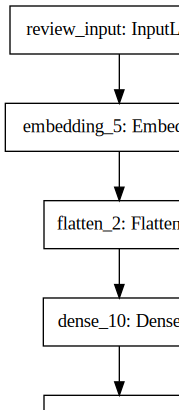

In [ ]:
# Add sequential model
sentiment_model = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Flatten_Layer = Flatten()
review_flatten = Flatten_Layer(review_embedding)
output_size = 2

dense1 = Dense(100,activation='relu')(review_flatten)

dense2 = Dense(32,activation='relu')(dense1)
predict = Dense(2,activation='softmax')(dense2)

sentiment_model = Model(inputs=[review_input],outputs=[predict])
sentiment_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(sentiment_model.summary())

SVG(model_to_dot(sentiment_model).create(prog='dot', format='svg'))

In [ ]:
sentiment_model.fit(X_train,y_train,epochs= 5,batch_size=32,verbose=True,validation_data=(X_test,y_test))

Epoch 1/5
257/257 [==============================] - 10s 37ms/step - loss: 0.3765 - acc: 0.8653 - val_loss: 0.2919 - val_acc: 0.8846
Epoch 2/5
257/257 [==============================] - 9s 36ms/step - loss: 0.1977 - acc: 0.9224 - val_loss: 0.2931 - val_acc: 0.8758
Epoch 3/5
257/257 [==============================] - 10s 37ms/step - loss: 0.0805 - acc: 0.9719 - val_loss: 0.3448 - val_acc: 0.8695
Epoch 4/5
257/257 [==============================] - 9s 37ms/step - loss: 0.0177 - acc: 0.9961 - val_loss: 0.5132 - val_acc: 0.8919
Epoch 5/5
257/257 [==============================] - 9s 36ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.5185 - val_acc: 0.8831


In [4]:
!pip install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=dcefd0fc9102616632c76dcd3ad0e136be3337c189e034f4fb03cb4903a86dbd
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
--2020-09-23 13:13:07--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.16.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.16.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  36.0MB/s    in 44s     

2020-09-23 13:13:52 (35.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [5]:
#Using word2vec
import gensim
from gensim.models import Word2Vec
embeddings_wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
embeddings_wv.init_sims(replace=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

embeddings_wv = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)  # C text format
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)  # C bin format

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import gensim.downloader as api

embeddings_ap = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
vocab = tokenizer.sequences_to_texts(texts)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))


for word, i in tokenizer.word_index.items():
	try:
		embedding_vector = embeddings_ap[word]
		if embedding_vector is not None:
			embedding_matrix[i] = embedding_vector
	except:
		pass

22814


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          2281400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 3,284,798
Trainable params: 3,284,798
Non-trainable params: 0
____________________________________________

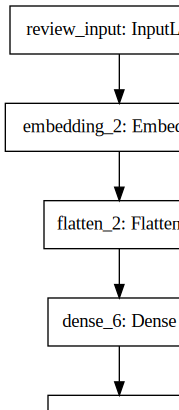

In [ ]:
sentiment_wv_model = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Word2Vec 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)

#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Flatten_Layer = Flatten()
review_flatten = Flatten_Layer(review_embedding)
output_size = 2

dense1 = Dense(100,activation='relu')(review_flatten)
dense2 = Dense(32,activation='relu')(dense1)
predict = Dense(2,activation='softmax')(dense2)

sentiment_wv_model = Model(inputs=[review_input],outputs=[predict])
sentiment_wv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(sentiment_wv_model.summary())
SVG(model_to_dot(sentiment_wv_model).create(prog='dot', format='svg'))

In [ ]:
sentiment_wv_model.fit(X_train,y_train,epochs= 5,batch_size=32,verbose=True,validation_data=(X_test,y_test))

Epoch 1/5
257/257 [==============================] - 7s 26ms/step - loss: 0.3696 - acc: 0.8756 - val_loss: 0.2962 - val_acc: 0.8914
Epoch 2/5
257/257 [==============================] - 6s 24ms/step - loss: 0.2088 - acc: 0.9183 - val_loss: 0.2787 - val_acc: 0.8831
Epoch 3/5
257/257 [==============================] - 6s 24ms/step - loss: 0.0788 - acc: 0.9732 - val_loss: 0.3806 - val_acc: 0.8782
Epoch 4/5
257/257 [==============================] - 6s 24ms/step - loss: 0.0189 - acc: 0.9952 - val_loss: 0.4651 - val_acc: 0.8855
Epoch 5/5
257/257 [==============================] - 6s 25ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.5484 - val_acc: 0.8894


In [ ]:
rom keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.utils import to_categorical

#Create a Model
model_cV = Sequential([
  Dense(64, activation='relu', input_shape=(inpShape,)),
  Dense(32, activation='relu'),
  Dense(2, activation='softmax'),
])

# Compile the model.
model_cV.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
# Train the model.
model_cV.fit(
  X_train,
  to_categorical(y_train),
  epochs=5,
  batch_size=32,
)

In [ ]:
model_cV.evaluate(
  X_test,
  to_categorical(y_test)
)

In [ ]:
# Predict on the first 5 test messages.
predictions = model_cV.predict(X_test[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) 

# Check our predictions against the ground truths.
print(y_test[:5]) 

In [ ]:
print(model_cV.summary())